# Data Cleaning and Feature Engineering for 30-day Readmission Dataset

This notebook loads the raw readmission features table, performs systematic data cleaning (missing-value analysis, row/column filtering, and categorical fills), imputes numeric features where appropriate, interpolates longitudinal lab values per patient (e.g., WBC), detects and clips outliers using quantile and clinically-informed ranges, constructs derived features and encodings for modeling, and saves a timestamped cleaned CSV for downstream analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/Users/xiaohei/Documents/Duke/Courses/526DataScience/Project/readmission_features_30d_v1.csv"
df = pd.read_csv(file_path)
print(f"Original data shape: {df.shape}")
df.head()

Original data shape: (546028, 51)


,subject_id,hadm_id,admittime,dischtime,readmit_label,days_since_prev_discharge,has_prior_admission,ed_visit_flag,ed_los_hours,length_of_stay,...,UreaNitrogen_median,WBC_median,Creatinine_max,Glucose_max,Hemoglobin_max,PlateletCount_max,Potassium_max,Sodium_max,UreaNitrogen_max,WBC_max
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,0,NaN,0,1,4.216667,0.786111,...,25.0,NaN,0.3,99.0,12.7,71.0,4.5,137.0,25.0,NaN
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,1,50.0,1,1,5.616667,1.015278,...,29.0,13.0,0.3,71.0,12.4,137.0,5.2,126.0,29.0,13.0
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,1,25.0,1,1,8.100000,2.222222,...,33.0,NaN,0.5,121.0,11.9,95.0,5.2,132.0,35.0,NaN
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,0,11.0,1,1,4.766667,1.754167,...,29.0,NaN,0.6,102.0,12.1,133.0,6.9,126.0,37.0,NaN
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,0,NaN,0,1,8.516667,0.298611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing Value Analysis

This section inspects column-wise and row-wise missingness to decide which columns or samples to drop, which categorical fields to fill with placeholders, and which numeric fields are appropriate for imputation.

In [21]:
# Check missing ratio
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print(missing_ratio)

ethnicity                    1.000000
WBC_median                   0.822480
WBC_min                      0.822480
WBC_max                      0.822480
days_since_prev_discharge    0.409232
discharge_location           0.274378
Glucose_max                  0.254154
Glucose_min                  0.254154
Glucose_median               0.254154
Sodium_min                   0.249498
Sodium_max                   0.249498
Sodium_median                0.249498
Potassium_max                0.246315
Potassium_min                0.246315
Potassium_median             0.246315
UreaNitrogen_max             0.245702
UreaNitrogen_min             0.245702
UreaNitrogen_median          0.245702
Creatinine_min               0.238440
Creatinine_median            0.238440
Creatinine_max               0.238440
Hemoglobin_median            0.226159
Hemoglobin_min               0.226159
Hemoglobin_max               0.226159
PlateletCount_median         0.223509
PlateletCount_min            0.223509
PlateletCoun

### Drop 'ethnicity' column

The 'ethnicity' column is removed because it is not required for downstream modeling and may contain sensitive or inconsistent entries. Removing it simplifies privacy considerations and modeling.

In [22]:
if "ethnicity" in df.columns:
    df.drop(columns=["ethnicity"], inplace=True)
    print("Dropped column: ethnicity")

Dropped column: ethnicity


In [23]:
df.shape

(546028, 50)

#### Drop rows with too many missing values

Rows where more than 50% of the features are missing will be dropped to improve overall data quality and reduce noise from extremely incomplete records.

In [ ]:
row_missing_threshold = 0.50

# compute missing ratio per row
row_missing_ratio = df.isnull().mean(axis=1)

# count rows that will be dropped
rows_to_drop = (row_missing_ratio > row_missing_threshold).sum()
print(f"Will drop {rows_to_drop:,} rows (missing ratio > {row_missing_threshold*100:.0f}%)")

# drop those rows
df = df.loc[row_missing_ratio <= row_missing_threshold].reset_index(drop=True)

# check shape after drop
print(f"Drop completed, current data shape: {df.shape}")

Will drop 39,609 rows (missing ratio > 50%)
Drop completed, current data shape: (506419, 50)


In [25]:
if 'discharge_location' in df.columns:
    df['discharge_location'].fillna('UNKNOWN', inplace=True)

# Fill categorical variables with 'UNKNOWN'
categorical_cols = ['language', 'marital_status', 'last_service']
for col in categorical_cols:
    if col in df.columns:
        df[col].fillna('UNKNOWN', inplace=True)

/var/folders/zz/6_300q_s6271hbkb3fpd2jnw0000gn/T/ipykernel_83977/974765241.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['discharge_location'].fillna('UNKNOWN', inplace=True)
/var/folders/zz/6_300q_s6271hbkb3fpd2jnw0000gn/T/ipykernel_83977/974765241.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [26]:
# Check missing ratio
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print(missing_ratio)

WBC_max                      0.808595
WBC_min                      0.808595
WBC_median                   0.808595
days_since_prev_discharge    0.364680
Glucose_max                  0.195818
Glucose_median               0.195818
Glucose_min                  0.195818
Sodium_max                   0.190799
Sodium_median                0.190799
Sodium_min                   0.190799
Potassium_max                0.187367
Potassium_median             0.187367
Potassium_min                0.187367
UreaNitrogen_max             0.186705
UreaNitrogen_median          0.186705
UreaNitrogen_min             0.186705
Creatinine_max               0.178876
Creatinine_min               0.178876
Creatinine_median            0.178876
Hemoglobin_max               0.165634
Hemoglobin_median            0.165634
Hemoglobin_min               0.165634
PlateletCount_max            0.162776
PlateletCount_median         0.162776
PlateletCount_min            0.162776
insurance                    0.010367
is_surgical_

#### Imputation strategy for numeric features (<= 20% missing)

Numeric columns with small-to-moderate missingness (greater than 0% and up to 20%) will be imputed using a multivariate approach (IterativeImputer) that leverages correlations between features.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Step 1: select numeric columns and compute missing ratios
num_cols = df.select_dtypes(include=["float", "int"]).columns
num_cols = [c for c in num_cols if c not in ["subject_id", "hadm_id"]]

missing_ratio = df[num_cols].isnull().mean()

# Keep only columns with missing rate > 0 and <= 20%
target_cols = missing_ratio[(missing_ratio > 0) & (missing_ratio <= 0.20)].index.tolist()

print(f"Number of numeric features with 0-20% missing: {len(target_cols)}")
display(missing_ratio[(missing_ratio > 0) & (missing_ratio <= 0.20)].sort_values(ascending=False))

# Step 2: use IterativeImputer to perform multivariate imputation
imputer = IterativeImputer(max_iter=10, random_state=42)

# impute the selected columns
df[target_cols] = imputer.fit_transform(df[target_cols])

# Step 3: check imputation results
missing_after = df[target_cols].isnull().mean()
compare = pd.DataFrame({
    "Before": missing_ratio[target_cols],
    "After": missing_after
}).sort_values("Before", ascending=False)

print("\nImputation completed! Before/after missing ratios:")
display(compare.head(15))

Number of numeric features with 0-20% missing: 22


Glucose_median          0.195818
Glucose_min             0.195818
Glucose_max             0.195818
Sodium_max              0.190799
Sodium_min              0.190799
Sodium_median           0.190799
Potassium_median        0.187367
Potassium_min           0.187367
Potassium_max           0.187367
UreaNitrogen_median     0.186705
UreaNitrogen_max        0.186705
UreaNitrogen_min        0.186705
Creatinine_min          0.178876
Creatinine_median       0.178876
Creatinine_max          0.178876
Hemoglobin_median       0.165634
Hemoglobin_min          0.165634
Hemoglobin_max          0.165634
PlateletCount_median    0.162776
PlateletCount_max       0.162776
PlateletCount_min       0.162776
is_surgical_service     0.000026
dtype: float64


Imputation completed! Before/after missing ratios:


,Before,After
Glucose_median,0.195818,0.0
Glucose_min,0.195818,0.0
Glucose_max,0.195818,0.0
Sodium_max,0.190799,0.0
Sodium_min,0.190799,0.0
Sodium_median,0.190799,0.0
Potassium_median,0.187367,0.0
Potassium_min,0.187367,0.0
Potassium_max,0.187367,0.0
UreaNitrogen_median,0.186705,0.0


In [28]:
# Check missing ratio
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print(missing_ratio)

WBC_max                      0.808595
WBC_min                      0.808595
WBC_median                   0.808595
days_since_prev_discharge    0.364680
insurance                    0.010367
admission_location           0.000002
PlateletCount_median         0.000000
PlateletCount_min            0.000000
Potassium_min                0.000000
Sodium_min                   0.000000
UreaNitrogen_min             0.000000
Creatinine_median            0.000000
Glucose_median               0.000000
Hemoglobin_median            0.000000
Potassium_median             0.000000
Glucose_min                  0.000000
Sodium_median                0.000000
UreaNitrogen_median          0.000000
Creatinine_max               0.000000
Glucose_max                  0.000000
Hemoglobin_max               0.000000
PlateletCount_max            0.000000
Potassium_max                0.000000
Sodium_max                   0.000000
UreaNitrogen_max             0.000000
Hemoglobin_min               0.000000
subject_id  

#### White Blood Cell (WBC) processing and interpolation

WBC-related fields are treated as time series per patient: admissions are ordered by time and linear interpolation is applied across admissions. Remaining missing values are filled with a default, and values are clipped to a clinically plausible range.

/var/folders/zz/6_300q_s6271hbkb3fpd2jnw0000gn/T/ipykernel_83977/3234337777.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('subject_id', group_keys=False).apply(interpolate_wbc_per_patient)
/var/folders/zz/6_300q_s6271hbkb3fpd2jnw0000gn/T/ipykernel_83977/3234337777.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

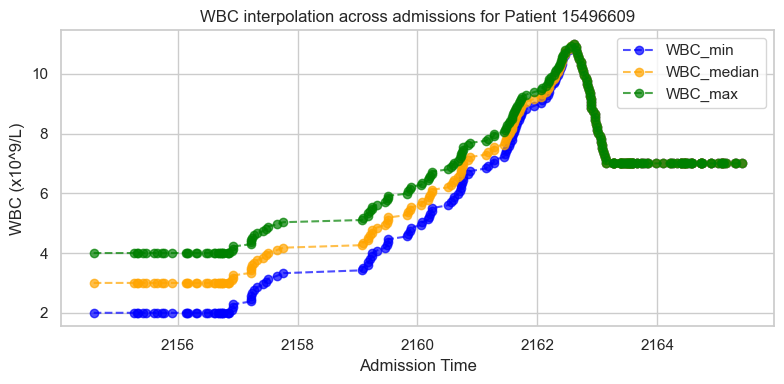

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert admittime to datetime and sort by patient/time
df['admittime'] = pd.to_datetime(df['admittime'], errors='coerce')
df = df.sort_values(['subject_id', 'admittime']).reset_index(drop=True)

# columns of interest for WBC
wbc_cols = ['WBC_min', 'WBC_median', 'WBC_max']

# 2. Create missing flags (not added to df)
missing_flags = {col: df[col].isna().astype(int) for col in wbc_cols}

# 3. Per-patient linear interpolation across admissions
def interpolate_wbc_per_patient(group):
    group = group.copy()
    for col in wbc_cols:
        if col in group.columns:
            group[col] = group[col].interpolate(method='linear', limit_direction='both')
    return group

df = df.groupby('subject_id', group_keys=False).apply(interpolate_wbc_per_patient)

# 4. Fill remaining missing values (e.g. first admission or all-missing) with default=7
for col in wbc_cols:
    if col in df.columns:
        df[col].fillna(7, inplace=True)

# 5. Clip to medically plausible range
for col in wbc_cols:
    df[col] = df[col].clip(lower=0.5, upper=50)

# 6. Visualization: example patient interpolation
example_id = df['subject_id'].value_counts().index[0]
sample = df[df['subject_id'] == example_id]

plt.figure(figsize=(8, 4))
for col, color in zip(wbc_cols, ['blue', 'orange', 'green']):
    plt.plot(sample['admittime'], sample[col], 'o--', label=col, alpha=0.7, color=color)

plt.title(f"WBC interpolation across admissions for Patient {example_id}")
plt.xlabel("Admission Time")
plt.ylabel("WBC (x10^9/L)")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print(missing_ratio)

days_since_prev_discharge    0.364680
insurance                    0.010367
admission_location           0.000002
subject_id                   0.000000
PlateletCount_median         0.000000
PlateletCount_min            0.000000
Potassium_min                0.000000
Sodium_min                   0.000000
UreaNitrogen_min             0.000000
WBC_min                      0.000000
Creatinine_median            0.000000
Glucose_median               0.000000
Hemoglobin_median            0.000000
Potassium_median             0.000000
Glucose_min                  0.000000
Sodium_median                0.000000
UreaNitrogen_median          0.000000
WBC_median                   0.000000
Creatinine_max               0.000000
Glucose_max                  0.000000
Hemoglobin_max               0.000000
PlateletCount_max            0.000000
Potassium_max                0.000000
Sodium_max                   0.000000
UreaNitrogen_max             0.000000
Hemoglobin_min               0.000000
death_within

#### Handling days_since_prev_discharge

Identify first admissions for each patient and assign a placeholder (999) for 'days_since_prev_discharge' where no previous discharge exists. This preserves information that the record is the first admission.

In [ ]:
# Ensure admittime is datetime and sort by subject_id + admittime
df['admittime'] = pd.to_datetime(df['admittime'], errors='coerce')
df = df.sort_values(['subject_id', 'admittime']).reset_index(drop=True)

# 2. Mark first admission and fill days_since_prev_discharge
# first record per patient -> no previous discharge
df['is_first_admission'] = df.groupby('subject_id').cumcount() == 0

# if first admission, set days_since_prev_discharge to 999
df.loc[df['is_first_admission'], 'days_since_prev_discharge'] = 999

print("Completed marking first admission and filling days_since_prev_discharge.")
print(df[['subject_id', 'admittime', 'days_since_prev_discharge', 'is_first_admission']].head(10))

Completed marking first admission and filling days_since_prev_discharge.
   subject_id           admittime  days_since_prev_discharge  \
0    10000032 2180-05-06 22:23:00                      999.0   
1    10000032 2180-06-26 18:27:00                       50.0   
2    10000032 2180-07-23 12:35:00                       25.0   
3    10000032 2180-08-05 23:44:00                       11.0   
4    10000084 2160-11-21 01:56:00                      999.0   
5    10000084 2160-12-28 05:11:00                       32.0   
6    10000117 2181-11-15 02:05:00                      999.0   
7    10000117 2183-09-18 18:10:00                      672.0   
8    10000161 2163-08-20 01:42:00                      999.0   
9    10000248 2192-11-30 01:25:00                      999.0   

   is_first_admission  
0                True  
1               False  
2               False  
3               False  
4                True  
5               False  
6                True  
7               False  
8     

In [32]:
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print(missing_ratio)

insurance                    0.010367
admission_location           0.000002
subject_id                   0.000000
Glucose_min                  0.000000
PlateletCount_min            0.000000
Potassium_min                0.000000
Sodium_min                   0.000000
UreaNitrogen_min             0.000000
WBC_min                      0.000000
Creatinine_median            0.000000
Glucose_median               0.000000
Hemoglobin_median            0.000000
PlateletCount_median         0.000000
Potassium_median             0.000000
Sodium_median                0.000000
UreaNitrogen_median          0.000000
WBC_median                   0.000000
Creatinine_max               0.000000
Glucose_max                  0.000000
Hemoglobin_max               0.000000
PlateletCount_max            0.000000
Potassium_max                0.000000
Sodium_max                   0.000000
UreaNitrogen_max             0.000000
WBC_max                      0.000000
Hemoglobin_min               0.000000
death_within

# Outlier detection and clipping

Visualize numeric feature distributions with boxplots, then reduce the influence of extremes using quantile-based clipping and clinically-informed value ranges for lab tests.

In [33]:
df.dtypes

subject_id                            int64
hadm_id                               int64
admittime                    datetime64[ns]
dischtime                            object
readmit_label                         int64
days_since_prev_discharge           float64
has_prior_admission                   int64
ed_visit_flag                         int64
ed_los_hours                        float64
length_of_stay                      float64
num_transfers                       float64
unique_careunits                    float64
had_icu_transfer_flag               float64
last_service                         object
is_surgical_service                 float64
gender                               object
anchor_age                            int64
language                             object
marital_status                       object
insurance                            object
admission_type                       object
admission_location                   object
discharge_location              

Number of numeric columns: 38
Example columns: ['readmit_label', 'days_since_prev_discharge', 'has_prior_admission', 'ed_visit_flag', 'ed_los_hours', 'length_of_stay', 'num_transfers', 'unique_careunits', 'had_icu_transfer_flag', 'is_surgical_service']


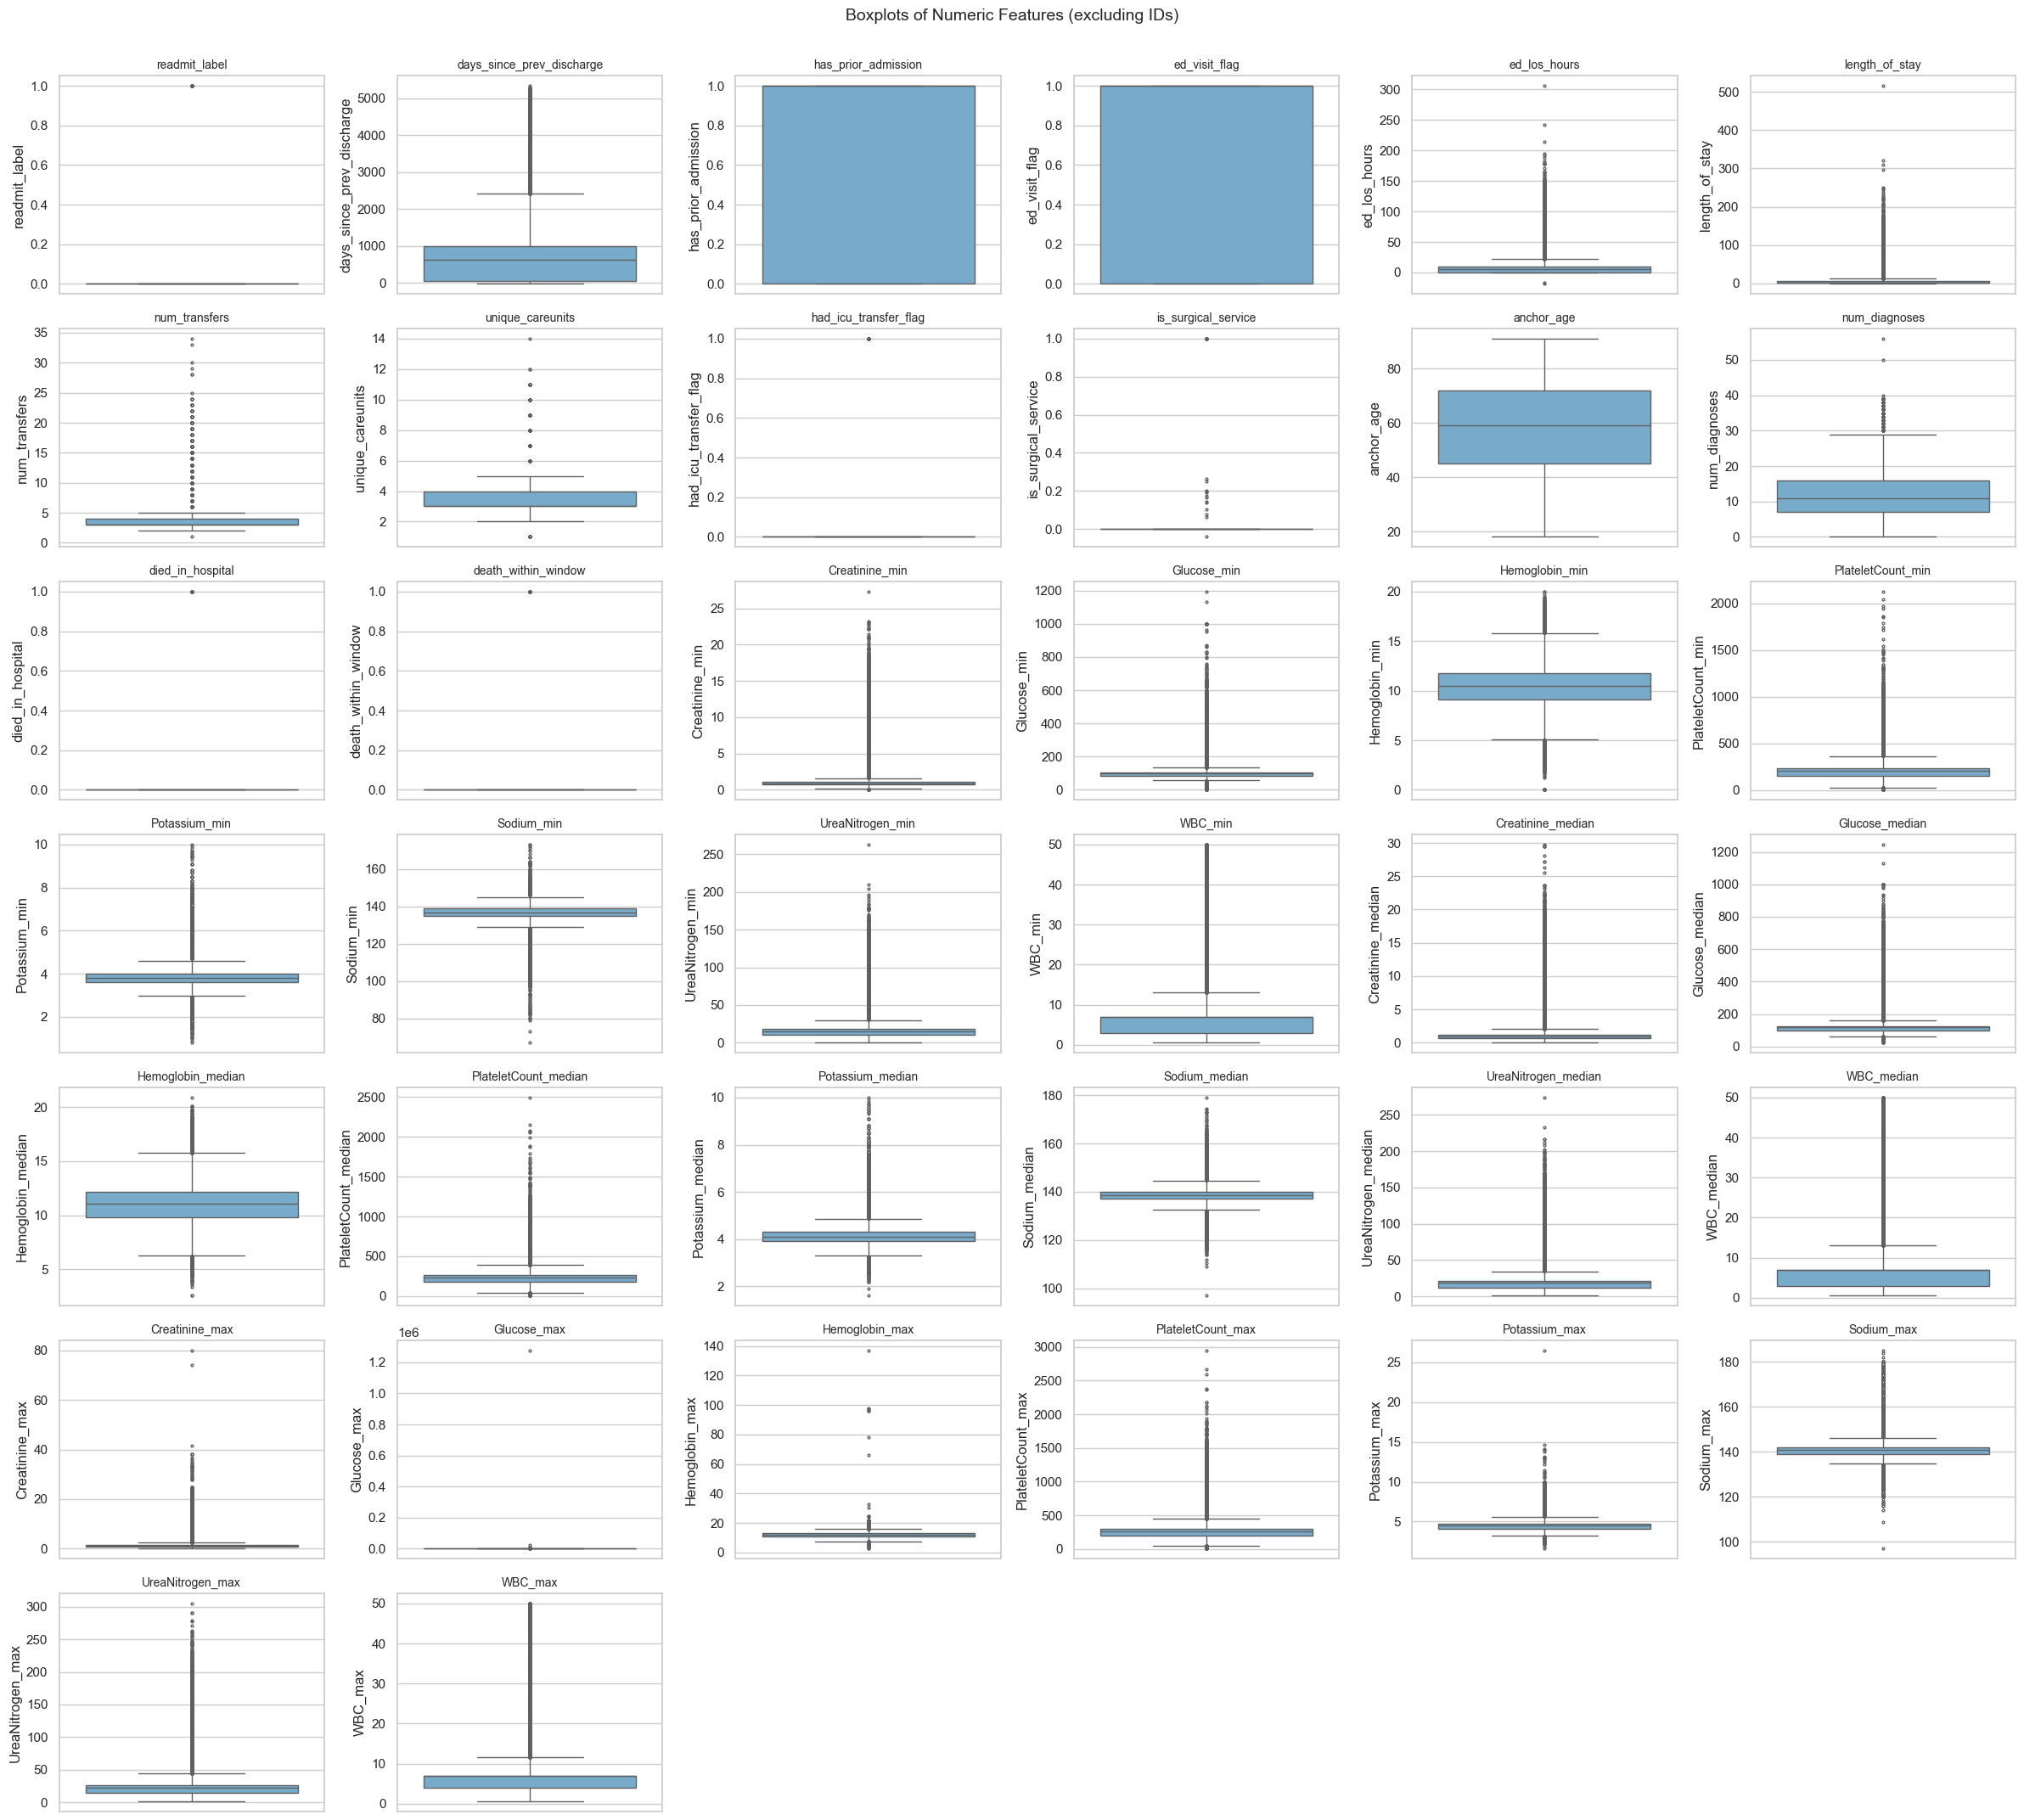

In [ ]:
# Select numeric columns (exclude ID columns)
num_cols = df.select_dtypes(include=['float', 'int']).columns
num_cols = [c for c in num_cols if c not in ['hadm_id', 'subject_id']]

print(f"Number of numeric columns: {len(num_cols)}")
print("Example columns:", num_cols[:10])

# unified plotting style
sns.set(style="whitegrid", palette="pastel")

# if many columns, plot in batches (6 per row)
cols_per_row = 6
num_plots = len(num_cols)
num_rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 4, num_rows * 3))

for i, col in enumerate(num_cols, 1):
    plt.subplot(num_rows, cols_per_row, i)
    sns.boxplot(y=df[col], color="#6baed6", fliersize=2)
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.suptitle("Boxplots of Numeric Features (excluding IDs)", fontsize=14, y=1.02)
plt.show()

In [ ]:
# ---- 1. Quantile-based clipping for general numeric columns ----
num_cols = df.select_dtypes(include=['float', 'int']).columns
num_cols = [c for c in num_cols if c not in ['hadm_id', 'subject_id']]

for col in num_cols:
    if not any(lab in col for lab in ['WBC','Hemoglobin','PlateletCount','Sodium','Potassium','Creatinine','UreaNitrogen','Glucose']):
        q_low, q_high = df[col].quantile([0.01, 0.99])
        df[col] = np.clip(df[col], q_low, q_high)

# ---- 2. Medical range-based clipping for lab values ----
lab_ranges = {
    'WBC': (0.5, 50),
    'Hemoglobin': (3, 20),
    'PlateletCount': (10, 2000),
    'Sodium': (100, 180),
    'Potassium': (1.5, 8.0),
    'Creatinine': (0.1, 15.0),
    'UreaNitrogen': (1, 200),
    'Glucose': (20, 800)
}

for lab, (low, high) in lab_ranges.items():
    for col in [c for c in df.columns if lab in c]:
        df[col] = np.clip(df[col], low, high)

print("Completed outlier clipping.")

Completed outlier clipping.


Number of numeric columns: 38
Example columns: ['readmit_label', 'days_since_prev_discharge', 'has_prior_admission', 'ed_visit_flag', 'ed_los_hours', 'length_of_stay', 'num_transfers', 'unique_careunits', 'had_icu_transfer_flag', 'is_surgical_service']


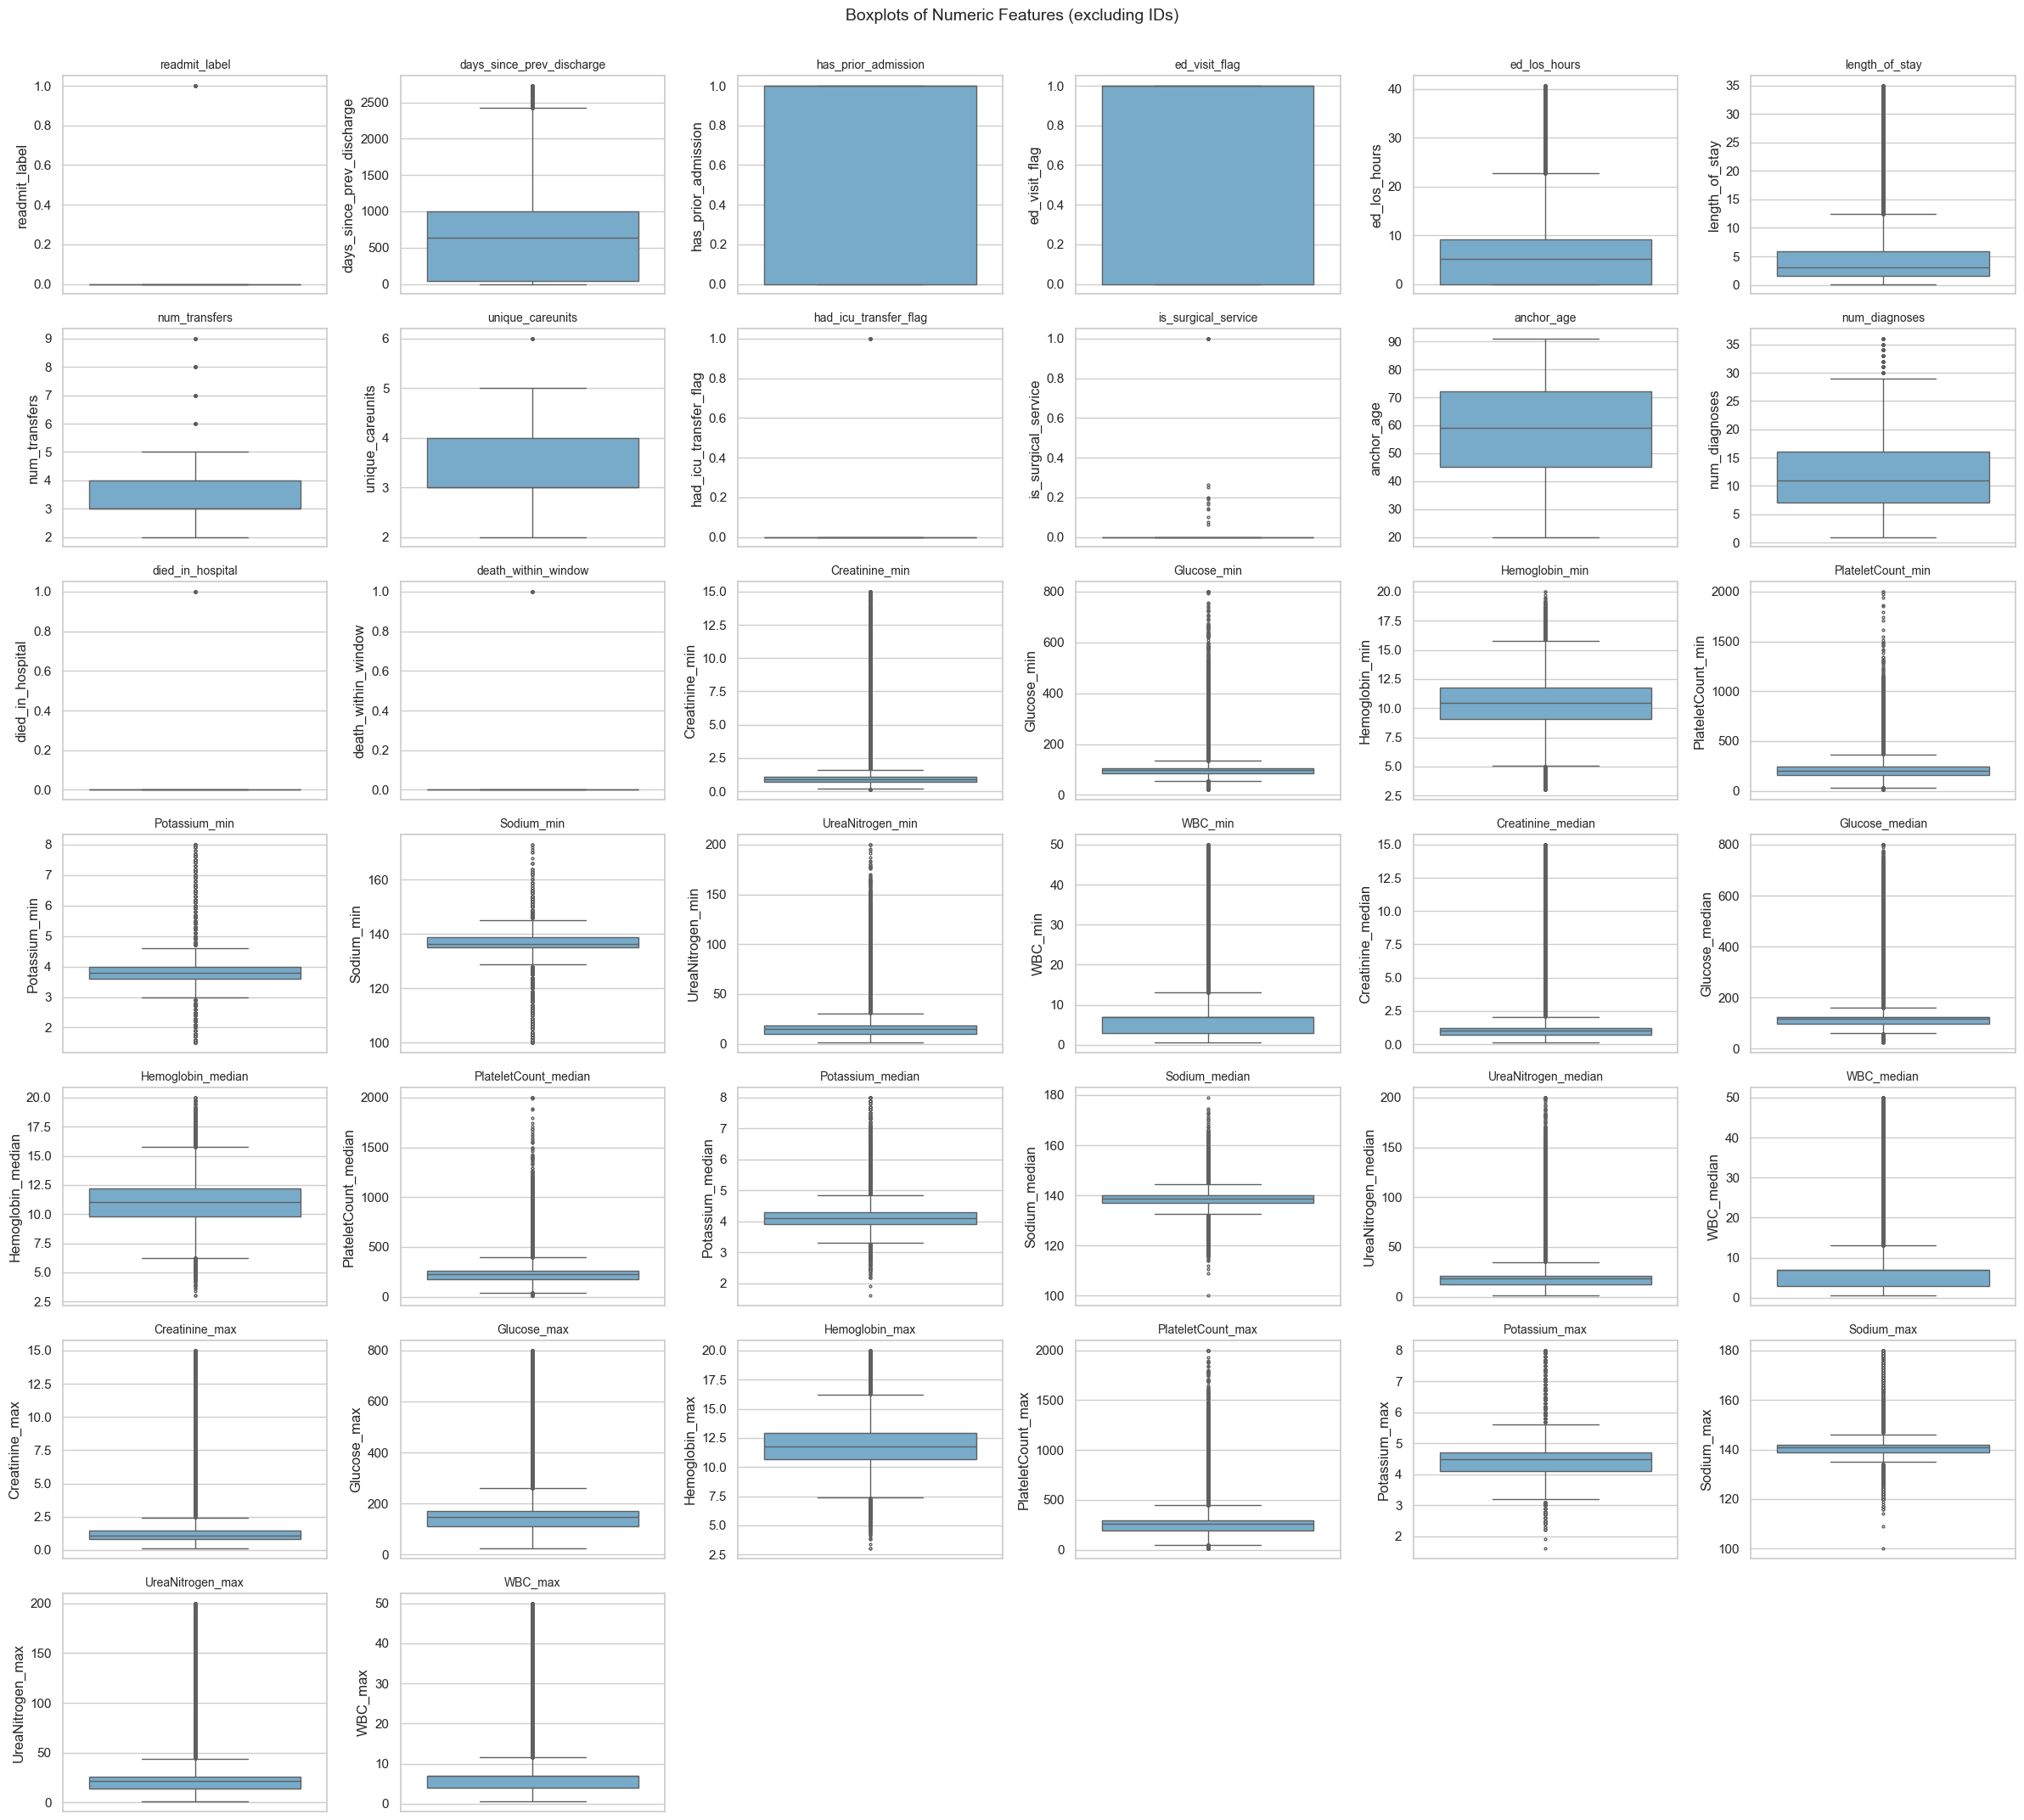

In [ ]:
# Select numeric columns (exclude ID columns)
num_cols = df.select_dtypes(include=['float', 'int']).columns
num_cols = [c for c in num_cols if c not in ['hadm_id', 'subject_id']]

print(f"Number of numeric columns: {len(num_cols)}")
print("Example columns:", num_cols[:10])

sns.set(style="whitegrid", palette="pastel")
cols_per_row = 6
num_plots = len(num_cols)
num_rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 4, num_rows * 3))

for i, col in enumerate(num_cols, 1):
    plt.subplot(num_rows, cols_per_row, i)
    sns.boxplot(y=df[col], color="#6baed6", fliersize=2)
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.suptitle("Boxplots of Numeric Features (excluding IDs)", fontsize=14, y=1.02)
plt.show()

# Feature Engineering and Categorical Encoding

Create derived features such as age groups, length-of-stay categories, ED stay duration categories, comorbidity score groups, and a binary high-risk flag. Extract admission season and one-hot encode low-cardinality categorical variables for modeling.

In [ ]:
# 1. Age grouping (age_group)
if 'anchor_age' in df.columns:
    df['age_group'] = pd.cut(
        df['anchor_age'],
        bins=[0, 35, 55, 75, 100],
        labels=['Young', 'Middle', 'Senior', 'Elderly'],
    )
    print("  Created feature: age_group")

# 2. Length of stay category (length_of_stay)
if 'length_of_stay' in df.columns:
    df['los_category'] = pd.cut(
        df['length_of_stay'],
        bins=[0, 1, 3, 7, float('inf')],
        labels=['Short', 'Medium', 'Long', 'Extended'],
    )
    print("  Created feature: los_category")

# 3. ED stay length category (ed_los_hours)
if 'ed_los_hours' in df.columns:
    df['ed_duration_category'] = pd.cut(
        df['ed_los_hours'],
        bins=[0, 2, 6, 12, float('inf')],
        labels=['Quick', 'Short', 'Medium', 'Long'],
    )
    print("  Created feature: ed_duration_category")

# 4. Comorbidity score grouping (comorbidity_score)
if 'num_diagnoses' in df.columns:
    df['comorbidity_score'] = pd.cut(
        df['num_diagnoses'],
        bins=[0, 3, 7, 15, float('inf')],
        labels=['Low', 'Medium', 'High', 'Very_High'],
    )
    print("  Created feature: comorbidity_score")

# 5. High risk patient flag (high_risk_patient)
risk_conditions = []
if 'had_icu_transfer_flag' in df.columns:
    risk_conditions.append(df['had_icu_transfer_flag'] == 1)
if 'died_in_hospital' in df.columns:
    risk_conditions.append(df['died_in_hospital'] == 1)
if 'num_transfers' in df.columns:
    risk_conditions.append(df['num_transfers'] > 3)

if risk_conditions:
    df['high_risk_patient'] = pd.concat(risk_conditions, axis=1).any(axis=1).astype(int)
    print("  Created feature: high_risk_patient")

# 6. Admission season features (admittime)
if 'admittime' in df.columns:
    df['admittime'] = pd.to_datetime(df['admittime'], errors='coerce')
    df['admission_month'] = df['admittime'].dt.month
    df['admission_season'] = df['admission_month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    print("  Created feature: admission_season")

# 7. Binary encode gender
if 'gender' in df.columns:
    df['gender_M'] = (df['gender'] == 'M').astype(int)
    df.drop(columns=['gender'], inplace=True)
    print("  Encoded gender into gender_M")

# 8. One-hot encode low-cardinality categorical variables
low_cardinality_cols = [
    'marital_status', 'insurance', 'age_group', 'los_category',
    'ed_duration_category', 'comorbidity_score', 'admission_season'

]

for col in low_cardinality_cols:
    if col in df.columns:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=[col], inplace=True)
        print(f"  One-hot encoded {col} ({len(dummies.columns)} new columns)")

print("Feature engineering & encoding completed.")
print(f"   Final shape: {df.shape}")

Starting feature engineering & categorical encoding ...
  Created feature: age_group
  Created feature: los_category
  Created feature: ed_duration_category
  Created feature: comorbidity_score
  Created feature: high_risk_patient
  Created feature: admission_season
  Encoded gender into gender_M
  One-hot encoded marital_status (4 new columns)
  One-hot encoded insurance (4 new columns)
  One-hot encoded age_group (3 new columns)
  One-hot encoded los_category (3 new columns)
  One-hot encoded marital_status (4 new columns)
  One-hot encoded insurance (4 new columns)
  One-hot encoded age_group (3 new columns)
  One-hot encoded los_category (3 new columns)
  One-hot encoded ed_duration_category (3 new columns)
  One-hot encoded comorbidity_score (3 new columns)
  One-hot encoded admission_season (3 new columns)
Feature engineering & encoding completed.
   Final shape: (506419, 74)
  One-hot encoded ed_duration_category (3 new columns)
  One-hot encoded comorbidity_score (3 new columns

# Save cleaned dataset

Save the cleaned and feature-engineered DataFrame to a CSV file with a timestamped filename and print the output path and final shape for tracking.

In [38]:
from datetime import datetime
from pathlib import Path

output_dir = Path("/Users/xiaohei/Documents/Duke/Courses/526 Data Science/Project")
output_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_file = output_dir / f"readmission_features_30d_v2_cleaned_{timestamp}.csv"

df.to_csv(output_file, index=False)

print(f"Data saved!")
print(f"   Path: {output_file}")
print(f"   Shape: {df.shape}")

Data saved!
   Path: /Users/xiaohei/Documents/Duke/Courses/526 Data Science/Project/readmission_features_30d_v2_cleaned_20251018_1611.csv
   Shape: (506419, 74)
